In [2]:
file_prefix <- "ch16.2"
reuse_fit <- T
source("preset.R")

input_file <- "data/TwoGroupIQ.csv"

In [4]:
data <- read_csv(input_file)
stan_data <- list(
  N = nrow(data), 
  Y = data$Score, 
  Y_MEAN = mean(data$Score), 
  Y_SD = sd(data$Score)
)

Parsed with column specification:
cols(
  Score = col_double(),
  Group = col_character()
)



In [6]:
init <- function() {
  list(
    mu = rnorm(1, stan_data$Y_MEAN, stan_data$Y_SD * 2), 
    sigma = runif(n = 1, stan_data$Y_SD / 1000, stan_data$Y_SD * 1000), 
    nu_minus_one = runif(1, 0, 60)
  )
}
fit <- stan(file = "model/ch16.2.stan", data = stan_data, init = init, seed = 1234, 
            chains = 4, warmup = 200, iter = 6000, thin = 1)

In [7]:
fit

Inference for Stan model: ch16.
4 chains, each with iter=6000; warmup=200; thin=1; 
post-warmup draws per chain=5800, total post-warmup draws=23200.

                mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
mu            102.83    0.01 1.60   99.71  101.77  102.81  103.87  105.99 16065
sigma          14.46    0.02 1.93   10.99   13.12   14.36   15.67   18.52 12423
nu_minus_one    2.54    0.02 1.82    0.75    1.52    2.15    3.05    6.65  9972
nu              3.54    0.02 1.82    1.75    2.52    3.15    4.05    7.65  9972
log_nu          0.51    0.00 0.16    0.24    0.40    0.50    0.61    0.88 11481
effect_size     0.20    0.00 0.11   -0.02    0.12    0.20    0.27    0.42 16651
lp__         -459.55    0.01 1.32 -462.97 -460.13 -459.21 -458.59 -458.09  8886
             Rhat
mu              1
sigma           1
nu_minus_one    1
nu              1
log_nu          1
effect_size     1
lp__            1

Samples were drawn using NUTS(diag_e) at Wed Jan 15 22:24:21 2020

In [ ]:
#ggmcmc(ggs(fit), file = plot_file_name("diag"))

In [8]:
# check result
res <- fit_to_tibble(fit) %>% 
  mutate(effect_size = (mu - 100) / sigma)

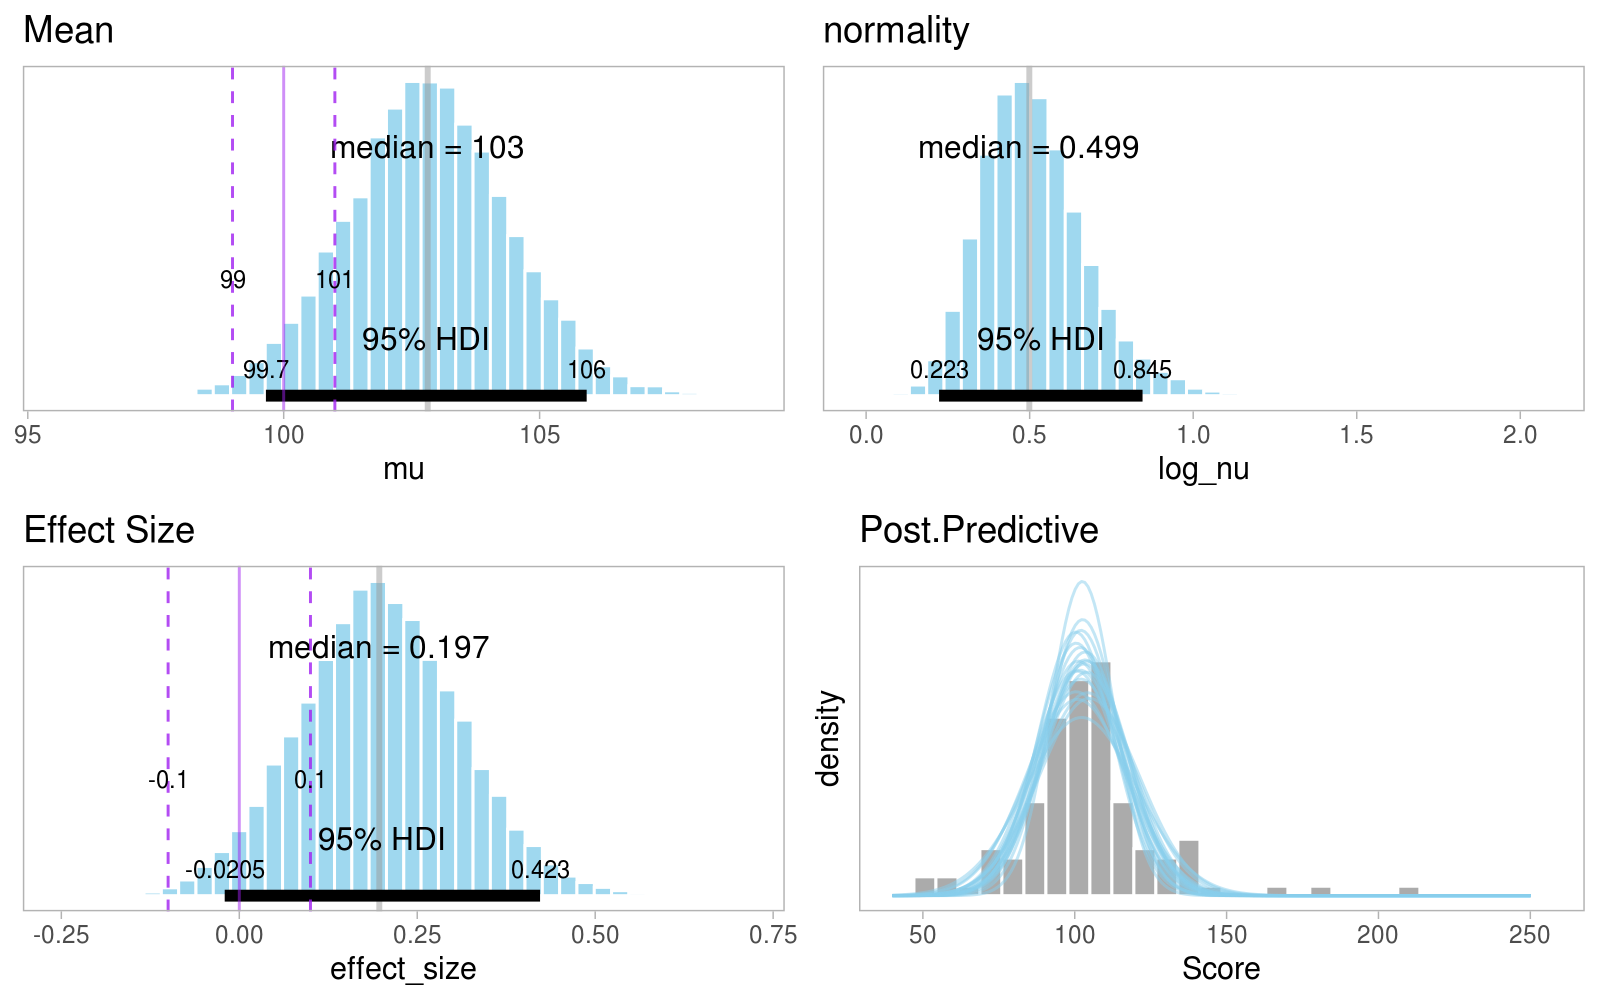

In [11]:
set_plot_size(8, 5)
grid.arrange(
  plot_post(res, "mu", rope = c(99, 101), title = "Mean"), 
  plot_post(res, "log_nu", title = "normality"), 
  plot_post(res, "effect_size", rope = c(-0.1, 0.1), title = "Effect Size"), 
  res %>% sample_n(20) %>% 
    make_line_grid(xs = seq(40, 250, length = 200), y_func = dnorm(Score, mu, sigma), x_name = "Score") %>% 
    ggplot(aes(Score)) + 
      geom_histogram(data = data, bins = 30, aes(y = ..density..), color = "white", alpha = 0.5) + 
      geom_line(aes(y = Y, group = line_id), color = "skyblue", alpha = 0.5) + 
      labs(title = "Post.Predictive") + 
      theme_post()
)